`flat_CNN.ipynb`

Create a convolutional neural network that uses filters of height = 1 to determine the slope angle of phase data. Each sample input will be an array of angle data, shape = (1x1024) (One time x 1024 frequency channels).

#### Imports & Setup

In [1]:
# check available GPU: watch -d -n 0.5 nvidia-smi
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2" 

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import io, os, sys

import pyuvdata
import hera_cal as hc
import uvtools

import threading
import random

#### Data

In [3]:
# load in data for a JD. 
data_directory = '../zen_data/'
miriad_path = data_directory + 'zen.2458098.58037.xx.HH.uv'

uvd = pyuvdata.UVData()
uvd.read_miriad(miriad_path)

# get the redundancies for that data
aa = hc.utils.get_aa_from_uv(uvd)
info = hc.omni.aa_to_info(aa)
red_bls = np.array(info.get_reds())

# gains for same data 
calfits_path = data_directory + 'zen.2458098.58037.xx.HH.uv.abs.calfits'
gains, flags = hc.io.load_cal(calfits_path)
gains_c = {key : gains[key].conjugate() for key in gains.keys()}

In [4]:
def ants_good(bl, gain_keys):
    """Returns True if BOTH antennas from bl are in gain_keys."""
    ants = [a[0] for a in gain_keys] 
    if bl[0] in ants and bl[1] in ants:
        return True
    else:
        return False

def elemental_baselines(red_bls):
    bls = []
    for sublist in sorted(red_bls):
        bls.append(sorted(sublist)[0])
    return sorted(bls)

def good_redundant_baselines_dict(good_redundant_baselines, elemental_baselines):
    bls_dict = {}
    for sublist in good_redundant_baselines:
        for elemental in elemental_baselines:
            if elemental in sublist:
                bls_dict[elemental] = sorted(sublist)
                break
    return bls_dict

In [5]:
# # run ONCE

# # eliminate baselines that are made up of only bad antennas
# # Also we need at least two baselines per group
# good_redundant_baselines = []
# for group in red_bls:
#     new_group = []
#     for bl in group:
#         if ants_good(bl, gains.keys()) == True:
#             new_group.append(bl)
#     new_group_len = len(new_group)
#     if new_group_len >= 4:
#         if new_group_len % 2 != 0:
#             new_group.pop()
#         good_redundant_baselines.append(sorted(new_group))

In [6]:
# training_redundant_baselines_dict = {}
# testing_redundant_baselines_dict = {}

# thinned_groups_dict = {}
# for group in good_redundant_baselines:
    
#     key = sorted(group)[0]
#     random.shuffle(group)
#     training_group = []
#     training_group.append(group.pop())
#     training_group.append(group.pop())
    
#     testing_group = []
#     testing_group.append(group.pop())
#     testing_group.append(group.pop())
    
#     training_redundant_baselines_dict[key] = training_group
#     testing_redundant_baselines_dict[key] = testing_group
#     if len(group) != 0:
#         thinned_groups_dict[key] = group

In [7]:
# thinned_dict_keys = thinned_groups_dict.keys()
# random.shuffle(thinned_dict_keys)

# training_redundant_baselines_extra, testing_redundant_baselines_extra = np.split(thinned_dict_keys, [int(len(thinned_dict_keys)*0.80)])

In [8]:
# for key in training_redundant_baselines_extra:
#     key = tuple(key)
#     group = thinned_groups_dict[key]
#     training_group = training_redundant_baselines_dict[key]
#     training_group.extend(group)
#     training_redundant_baselines_dict[key] = training_group

In [9]:
# for key in testing_redundant_baselines_extra:
#     key = tuple(key)
#     group = thinned_groups_dict[key]
#     testing_group = testing_redundant_baselines_dict[key]
#     testing_group.extend(group)
#     testing_redundant_baselines_dict[key] = testing_group

In [10]:
# np.savez('training_redundant_baselines_dict', training_redundant_baselines_dict)
# np.savez('testing_redundant_baselines_dict', testing_redundant_baselines_dict)

In [11]:
from numpy import load
def loadnpz(filename):
    a = load(filename)
    d = dict(zip(("data1{}".format(k) for k in a), (a[k] for k in a)))
    return d['data1arr_0']

training_redundant_baselines_dict = loadnpz('training_redundant_baselines_dict.npz')[()]
testing_redundant_baselines_dict = loadnpz('testing_redundant_baselines_dict.npz')[()]

In [12]:

# baselines as keys
training_baselines_data = {}
for key in training_redundant_baselines_dict.keys():
    for bl in training_redundant_baselines_dict[key]:
        training_baselines_data[bl] = uvd.get_data(bl)

training_baselines_data_c = {key : training_baselines_data[key].conjugate() for key in training_baselines_data.keys()}

testing_baselines_data = {}
for key in testing_redundant_baselines_dict.keys():
    for bl in testing_redundant_baselines_dict[key]:
        testing_baselines_data[bl] = uvd.get_data(bl)
        
testing_baselines_data_c = {key : testing_baselines_data[key].conjugate() for key in testing_baselines_data.keys()}

In [13]:
# scaling tools
angle_tx =  lambda x: (np.array(x) + np.pi)/(2*np.pi)
angle_itx = lambda x: np.array(x)*2*np.pi - np.pi

delay_tx = lambda x: (np.array(x) + 0.040)/(2*0.040)
delay_itx = lambda x: np.array(x)*2*0.040 - 0.040

In [14]:
class Data_Creator(object):
## usage:
## data_maker = data_creator(num_flatnesses=250, mode = 'train')
## data_maker.gen_data() (before loop)
## inputs, targets = data_maker.get_data() (start of loop)
## data_maker.gen_data() (immediately after get_data())

    def __init__(self, num_flatnesses, mode = 'train'):
        
        self.num = num_flatnesses
        self.mode = mode
        
        self.data = []
        
        
    def _gen_data(self):
        
        nu = np.arange(1024)
        
        if self.mode == 'clean':
            targets = np.random.uniform(low = -.040, high = 0.040, size = (self.num*60,1))
            inputs = np.angle(np.exp(-2j*np.pi*(targets*nu + np.random.uniform())))
            d = angle_tx(inputs), delay_tx(targets)
            self.data.append(d)
            
        else:

            def _flatness(baselines, data, data_c):
                """Create a flatness from a given pair of baselines, their data & their gains."""

                a, b = baselines[0][0], baselines[0][1]
                c, d = baselines[1][0], baselines[1][1]

                return data[baselines[0]]*data_c[baselines[1]] * gains_c[(a,'x')] * gains[(b,'x')] * gains[(c,'x')] * gains_c[(d,'x')]

            if self.mode == 'train':
                elemental_baselines = training_redundant_baselines_dict.keys()
                baselines_dict = training_redundant_baselines_dict
                baseline_data = training_baselines_data
                baseline_data_c = training_baselines_data_c

            if self.mode == 'test':
                elemental_baselines = testing_redundant_baselines_dict.keys()
                baselines_dict = testing_redundant_baselines_dict
                baseline_data = testing_baselines_data
                baseline_data_c = testing_baselines_data_c

            inputs = []
            for _ in range(self.num):

                elemental_baseline = random.sample(elemental_baselines, 1)[0]
                two_baselines = [random.sample(baselines_dict[elemental_baseline], 2)][0]
                inputs.append(_flatness(two_baselines, baseline_data, baseline_data_c))

            targets = np.random.uniform(low = -.040, high = 0.040, size = (self.num*60, 1))
            inputs = np.angle(np.array(inputs).reshape(-1,1024) * np.exp(-2j*np.pi*(targets*nu + np.random.uniform())))

            d = angle_tx(inputs), delay_tx(targets)
            self.data.append(d)

    def gen_data(self):
        self.thread = threading.Thread(target = self._gen_data, args=())
        self.thread.start()

    def get_data(self, timeout = 10):
        
        if len(self.data) == 0:
            self.thread.join(timeout)
            
        return self.data.pop(0)



In [15]:
def gen_plot(predicted_values, actual_values):
    """Create a prediction plot and save to byte string."""

    prediction_unscaled = delay_itx(predicted_values)
    actual_unscaled = delay_itx(actual_values)

    sorting_idx = np.argsort(actual_unscaled.T[0])

    fig, ax = plt.subplots(figsize = (5, 3), dpi = 144)

    ax.plot(prediction_unscaled.T[0][sorting_idx],
            linestyle = 'none', marker = '.', markersize = 1,
            color = 'darkblue')

    ax.plot(actual_unscaled.T[0][sorting_idx],
            linestyle = 'none', marker = '.', markersize = 1, alpha = 0.50,
            color = '#E50000')       

    ax.set_title('std: %.9f' %np.std(prediction_unscaled.T[0][sorting_idx] - actual_unscaled.T[0][sorting_idx]))

    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi = 144)
    plt.close(fig)
    buf.seek(0)

    return buf.getvalue()



#### Network

In [19]:
class Flat_CNN(object):
    """A neural network of multi-path layers. Filters for each path have shape_height = 1"""
    
    def __init__(self,
                 wide_filter_widths = [],
                 width_reduction_factors = [],
                 dtype = tf.float32,
                 num_freq_channels = 1024,
                 learning_rate = 0.0001):

        self.wide_filter_widths = wide_filter_widths
        self.width_reduction_factors = width_reduction_factors
        self.dtype = dtype
        self.num_freq_channels = num_freq_channels
        self.learning_rate = learning_rate
        
        self.num_layers = len(self.wide_filter_widths)
        
        
    def _quad_path_layer(self, input, wide_conv_width, strides, layer_name, num_1x1_conv_filters = 4):

        # convolution filters
        conv_filters = lambda shape : tf.get_variable(name = 'filters',
                                                      dtype = self.dtype,
                                                      shape = shape,
                                                      initializer = tf.contrib.layers.xavier_initializer())


        def _bias_add_scope(input, shape):
            """Creates a scope around a trainable bias and its addition to input"""
            with tf.variable_scope('add_bias'):

                bias = tf.get_variable(name = 'bias', dtype = self.dtype, shape = shape, initializer = tf.contrib.layers.xavier_initializer())
                bias_add = tf.nn.bias_add(input, bias)

            return bias_add


        def _conv_scope(input, filter_shape, strides, scope_name = 'convolution'):
            """Creates a scope around a convolution."""
            with tf.variable_scope(scope_name):

                conv = tf.nn.conv2d(input = input, filter = conv_filters(filter_shape), strides = strides, padding = 'SAME') 
                conv = _bias_add_scope(conv, [filter_shape[-1]])
                conv = tf.nn.relu(conv)
                conv = tf.nn.dropout(conv, self.conv_keep_prob)

            return conv

        def _avg_scope(input, strides, num_conv_filters):
            """Creates a scope around the average-pool path."""
            with tf.variable_scope('average'):
                avg_pool = tf.nn.avg_pool(value = input, ksize = strides, strides = strides, padding = "SAME")

                convolution_filter_shape = [1,1,avg_pool.get_shape().as_list()[3], num_conv_filters]
                avg = _conv_scope(avg_pool, convolution_filter_shape, [1,1,1,1], scope_name = "1x1_conv")

            return avg

        def _max_scope(input, strides,  num_conv_filters):
            """Creates a scope around the max-pool path"""
            with tf.variable_scope('max'):
                max_pool = tf.nn.max_pool(value = input, ksize = strides, strides = strides, padding = "SAME")

                convolution_filter_shape = [1,1,max_pool.get_shape().as_list()[3],num_conv_filters]
                max_ = _conv_scope(max_pool, convolution_filter_shape, [1,1,1,1], scope_name = "1x1_conv")

            return max_

        def _filter_cat_scope(filters):
            """Creates a scope around filter concatation (layer output)"""
            with tf.variable_scope('filter_cat'):
                filter_cat = tf.concat(filters, 3)
            return filter_cat

        ######

        with tf.variable_scope(layer_name):

            narrow_conv_width = wide_conv_width / 2

            num_narrow_conv_filters = num_1x1_conv_filters / 2
            num_wide_conv_filters = num_narrow_conv_filters / 2

            _1x1_strides = [1,1,1,1]

            avg_output = _avg_scope(input, strides, num_1x1_conv_filters)
            max_output = _max_scope(input, strides, num_1x1_conv_filters)

            inital_conv = _conv_scope(input, [1,1,input.get_shape().as_list()[3],num_1x1_conv_filters], [1,1,1,1], '1x1_conv')

            narrow_convolution = _conv_scope(inital_conv, [1,narrow_conv_width,inital_conv.get_shape().as_list()[3],num_narrow_conv_filters], strides, scope_name = 'narrow')
            wide_convolution = _conv_scope(inital_conv, [1,wide_conv_width,inital_conv.get_shape().as_list()[3],num_wide_conv_filters], strides, scope_name = 'wide')

            catted_filters = _filter_cat_scope([avg_output, narrow_convolution, wide_convolution, max_output])

        return catted_filters
    




        
    def create_graph(self):
        # creates the network graph
        tf.reset_default_graph()

        # Note, tf.placeholder() are assigned by tf.Session()

        with tf.variable_scope('keep_probs'):
            # Dropout rate = 1 - keep_prob

            # probability of keeping sample_keep_prob
            # suggest 0.8
            self.sample_keep_prob = tf.placeholder(self.dtype, name = 'sample_keep_prob')

            # probability of keeping convolution output
            # suggest 0.9
            self.conv_keep_prob = tf.placeholder(self.dtype, name = 'conv_keep_prob')

            # probability of keeping fully connected layer output
            # suggest 0.95
            self.fcl_keep_prob = tf.placeholder(self.dtype, name = 'fcl_keep_prob')        

        with tf.variable_scope('sample'):
            # holds the 1 x num_channels samples that are fed into the network
            self.X = tf.placeholder(self.dtype, shape = [None, 1, self.num_freq_channels, 1], name = 'X')
            self.X_dropout = tf.nn.dropout(self.X, self.sample_keep_prob)

        self.layers = []
        layer_names = ['layer_{}'.format(i) for i in range(self.num_layers)]

        for i in range(self.num_layers):
            # previous layer is input for current layer
            input = self.X_dropout if i == 0 else self.layers[i - 1]
            strides = [1, 1, self.width_reduction_factors[i], 1]
            q_layer = self._quad_path_layer(input, self.wide_filter_widths[i], strides, layer_names[i])
            self.layers.append(q_layer)
                
        with tf.variable_scope('fcl_1'):
            
            fcl_1 = tf.contrib.layers.flatten(self.layers[-1])
            fcl_1 = tf.contrib.layers.fully_connected(fcl_1, 1024)
            fcl_1 = tf.nn.dropout(fcl_1, self.fcl_keep_prob)
                
            self.layers.append(fcl_1)
            
        with tf.variable_scope('fcl_2'):
            
            fcl_2 = tf.contrib.layers.flatten(self.layers[-1])
            fcl_2 = tf.contrib.layers.fully_connected(fcl_1, 32)
            fcl_2 = tf.nn.dropout(fcl_2, self.fcl_keep_prob)
                                
            self.layers.append(fcl_2)
            
        with tf.variable_scope('prediction'):
            reshape_final_layer = tf.reshape(self.layers[-1], [-1, np.prod(self.layers[-1].get_shape().as_list()[1:])])
            prediction_weight = tf.get_variable(name = 'weight', shape = [np.prod(self.layers[-1].get_shape()[1:]), 1.], dtype = self.dtype, initializer = tf.contrib.layers.xavier_initializer())
            pred_times_weight = tf.matmul(reshape_final_layer, prediction_weight)
            self.predictions = tf.nn.bias_add(pred_times_weight, [1])

        with tf.variable_scope('targets'):
            self.targets = tf.placeholder(dtype = self.dtype, shape = [None, 1], name = 'targets')

        with tf.variable_scope('costs'):

            self.error = tf.subtract(self.targets, self.predictions, name = 'error')
            self.squared_error = tf.square(self.error, name = 'squared_difference')

            with tf.variable_scope('mean_inverse_shifted_gaussian'):
                with tf.variable_scope('normal_distribution'):
                    self.threshold = 0.00625
                    sigma = tf.constant(self.threshold, name = 'sigma')
                    normal_dist = tf.contrib.distributions.Normal(0.0, sigma, name = 'normal_dist')
                    gaussian_prob = normal_dist.prob(self.error, name = 'gaussian_prob')
                    shifted_gaussian = tf.add(gaussian_prob, .01, name = 'shifted_gaussian')        

                self.MISG = tf.reduce_mean(tf.divide(1.0, shifted_gaussian), name = 'mean_inverse_shifted_gaussian')

            with tf.variable_scope('mean_squared_error'):
                self.MSE = tf.reduce_mean(self.squared_error)

        with tf.variable_scope('train'):

            self.optimizer = tf.train.AdamOptimizer(self.learning_rate, epsilon=1e-08).minimize(self.MSE)

        with tf.variable_scope('logging'):  

            with tf.variable_scope('image'):
                self.image_buf = tf.placeholder(tf.string, shape=[])
                epoch_image = tf.expand_dims(tf.image.decode_png(self.image_buf, channels=4), 0)

            with tf.variable_scope('percent_within_threshold'):
                self.PWT = 100.*tf.reduce_mean(tf.cast(tf.less_equal(tf.abs(self.targets - self.predictions), self.threshold), self.dtype))


            tf.summary.histogram(name = 'targets', values = self.targets)
            tf.summary.histogram(name = 'predictions',values =  self.predictions)
            tf.summary.scalar(name = 'MSE', tensor = self.MSE)
            tf.summary.scalar(name = 'MISG', tensor = self.MISG)
            tf.summary.scalar(name = 'PWT', tensor = self.PWT)
            tf.summary.image('prediction_vs_actual', epoch_image)
            self.summary = tf.summary.merge_all()    

#### Training

In [20]:
def train(network, num_flatnesses, num_epochs, batch_size, log_dir, model_save_interval, pretrained_model_path = None, sample_keep_prob = 0.80, conv_keep_prob = 0.9, fcl_keep_prob = 0.50):

    num = num_flatnesses
    num_entries = num * 60

    MISG = []
    MSE = []

    train_batcher = Data_Creator(num, mode = 'train')
    train_batcher.gen_data()


    test_batcher = Data_Creator(num, mode = 'test')
    test_batcher.gen_data()
    saver = tf.train.Saver()

    with tf.Session() as session:

        if pretrained_model_path == None:
            session.run(tf.global_variables_initializer())
        else:
            saver.restore(session, pretrained_model_path)

        training_writer = tf.summary.FileWriter(log_dir + '/training', session.graph)
        testing_writer = tf.summary.FileWriter(log_dir + '/testing', session.graph)
        model_save_location = log_dir + '/trained_model.ckpt'   

        for epoch in range(num_epochs):

            training_inputs, training_targets = train_batcher.get_data(); train_batcher.gen_data()
            testing_inputs, testing_targets = test_batcher.get_data(); test_batcher.gen_data()  

            for j in range(int(num_entries/batch_size)):

                training_inputs_batch = training_inputs[j*batch_size:(j + 1)*batch_size].reshape(-1,1,1024,1)
                training_targets_batch = training_targets[j*batch_size:(j + 1)*batch_size].reshape(-1,1)
                

                session.run([network.optimizer], feed_dict = {network.X: training_inputs_batch,
                                                              network.targets: training_targets_batch,
                                                              network.sample_keep_prob : sample_keep_prob,
                                                              network.conv_keep_prob : conv_keep_prob,
                                                              network.fcl_keep_prob : fcl_keep_prob}) 
            # Prediction: Scaled Train(ing results)   
            PST = session.run(network.predictions,
                              feed_dict = {network.X: training_inputs.reshape(-1,1,1024,1),
                                           network.sample_keep_prob : 1.,
                                           network.conv_keep_prob : 1.,
                                           network.fcl_keep_prob : 1.}) 


            training_MISG, training_MSE, training_summary = session.run([network.MISG, network.MSE, network.summary],
                                                                        feed_dict = {network.X: training_inputs.reshape(-1,1,1024,1),
                                                                        network.targets: training_targets.reshape(-1,1),
                                                                        network.sample_keep_prob : 1.,
                                                                        network.conv_keep_prob : 1.,
                                                                        network.fcl_keep_prob : 1.,
                                                                        network.image_buf: gen_plot(PST,training_targets)}) 

            sys.stdout.write('\r' + "Epoch: " + str(epoch) + ". Training: MISG = {:.6f}, MSE = {:.6f}".format(training_MISG, training_MSE))

            training_writer.add_summary(training_summary, epoch)
            training_writer.flush()  

            # Prediction: Scaled test(ing results)   
            PSt = session.run(network.predictions,
                              feed_dict = {network.X: testing_inputs.reshape(-1,1,1024,1),
                                           network.sample_keep_prob : 1.,
                                           network.conv_keep_prob : 1.,
                                           network.fcl_keep_prob : 1.}) 

            testing_MISG, testing_MSE, testing_summary = session.run([network.MISG, network.MSE, network.summary],
                                                                      feed_dict = {network.X: testing_inputs.reshape(-1,1,1024,1),
                                                                                   network.targets: testing_targets.reshape(-1,1),
                                                                                   network.sample_keep_prob : 1.,
                                        
                                                                                   network.conv_keep_prob : 1.,
                                                                                   network.fcl_keep_prob : 1.,
                                                                                   network.image_buf: gen_plot(PSt,testing_targets)}) 

            sys.stdout.write('\r' + "Epoch: " + str(epoch) + ".  Testing: MISG = {:.6f}, MSE = {:.6f}".format(testing_MISG, testing_MSE))

            testing_writer.add_summary(testing_summary, epoch)
            testing_writer.flush()  

            MISG.append((training_MISG, testing_MISG))
            MSE.append((training_MSE, testing_MSE))

            if (epoch + 1) % model_save_interval == 0:
                saver.save(session, model_save_location, epoch)



        print('\rDone')

        training_writer.close()
        testing_writer.close()

    session.close()

Epoch: 1. Training: MISG = 94.345909, MSE = 0.084133

KeyboardInterrupt: 

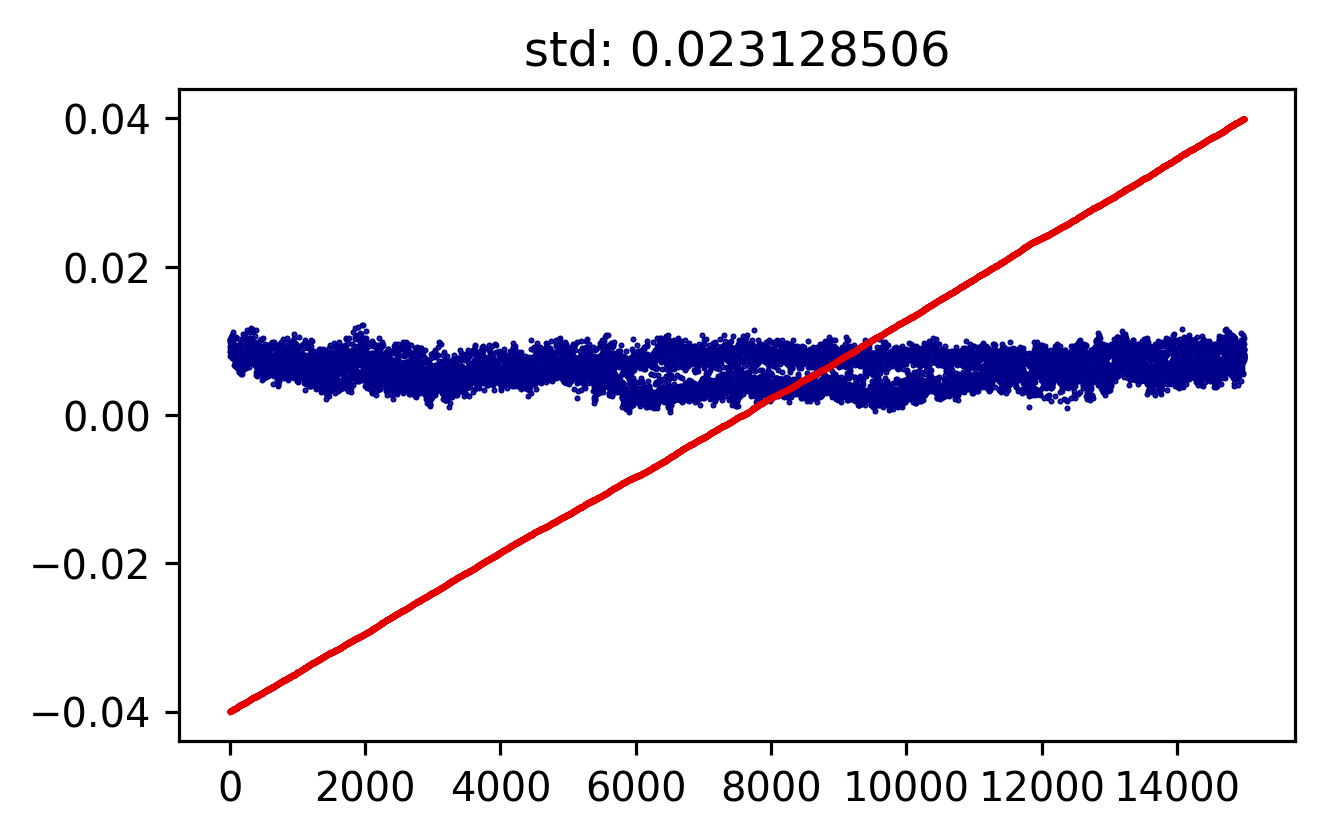

In [20]:
# doesnt crash :)

network = Flat_CNN([32,16,8,4], [2,2,2,2], learning_rate = 0.0005)
network.create_graph()
train(network, 250, 100, 32, 'logs/Test-B', 25)
# test-B, LR *=5
# TODO?: add logging/std